In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import scipy.linalg

from k4_prime import *

plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

In [2]:
def spectrum_any(lap, tol=1e-12):
    symmetric = np.allclose(lap, lap.T, atol=tol)
    
    eigvals_u, l_eigvecs_u, r_eigvecs_u = scipy.linalg.eig(lap, left=True, right=True)

    if symmetric:
        # Clean up tiny numerical imaginary parts for symmetric case
        eigvals_u = eigvals_u.real
        r_eigvecs_u = r_eigvecs_u.real
        l_eigvecs_u = l_eigvecs_u.real
        
    idx = np.argsort(eigvals_u.real)
    lambdas = eigvals_u[idx]
    z_i = r_eigvecs_u[:, idx]
    l_eigvecs_u = l_eigvecs_u[:, idx]

    # Left eigenvectors as rows (conjugate transpose)
    w_i = l_eigvecs_u.conj().T
    
    return lambdas, w_i, z_i

In [3]:
def pi_dist(lap):
    """
    Computes the steady-state distribution directly from the spectrum of a given Laplacian matrix. This function works for a linear framework graph of any size.
    """
    eigvals, eigvecs = scipy.linalg.eig(lap)
    v = eigvecs[:, np.argmin(np.abs(eigvals))].real
    pi = v / v.sum()
    return pi

In [4]:
def normalization_factors(w_i, z_i):
    r_i = np.zeros(z_i.shape[1], dtype=complex)  # one factor per eigenpair
    for k in range(z_i.shape[1]):
        r_i[k] = np.vdot(w_i[k,:], z_i[:, k])  # vdot does conjugate on first arg
    return r_i

In [5]:
def projection_matrices(w_i, z_i, r):
    N = z_i.shape[0]
    m = z_i.shape[1]  # number of eigenpairs
    Lk_list = []
    for k in range(m):
        zk = z_i[:, [k]]   # column vector (N x 1)
        wk = w_i[[k], :]   # column vector (N x 1)
        Lk = (1 / r[k]) * (zk @ wk)  # outer product gives N x N
        Lk_list.append(Lk)
    return Lk_list

In [6]:
def B_matrix(lambdas, Lk_list, delta_u_star):
    N = delta_u_star.shape[0]
    # skip k=0 since lambdas[0] is zero for Laplacian
    Bsum = sum((1/lambdas[k]) * Lk_list[k] for k in range(0, N-2))
    return Bsum @ delta_u_star

In [7]:
def skew_symmetric_area(signal, B, alpha=1,beta=3):
    """
    Computes the Steinberg signature / area for given vectors S_alpha, S_beta
    and the operator B(G).
    """
    # define the signal vectors
    s_t = np.array([signal],dtype=float) # row vector
    s = s_t.T # column vector
    
    # Form the skew-symmetric combination
    B_skew = B - B.T
    area = (s_t**beta) @ B_skew @ (s ** alpha)
    return area

In [8]:
def steinberg_analytical_area(signal,lap,alpha=1,beta=3):
    lambdas, w_i, z_i = spectrum_any(lap)
    r_i = normalization_factors(w_i, z_i)
    Lk_list = projection_matrices(w_i, z_i, r_i)
    pi = np.array(pi_dist(lap))
    delta_u_star = np.diag(pi)
    B = B_matrix(lambdas, Lk_list, delta_u_star)
    area = skew_symmetric_area(signal, B, alpha=1,beta=3)

    return area.real.item()

Equilibrium check: is the area zero when the affinity is zero?

In [10]:
labels_f, labels_r = eq_params_k4_2cycle()

aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

lap = lap_k4_2cycle(labels_f, labels_r)
print(lap)

signal = [3,5,7,9]
alpha, beta  = 1, 3

area = steinberg_analytical_area(signal,lap,alpha=1,beta=3)
print(area)

0.0
[[-5.88208861e-01  7.37200000e+01  0.00000000e+00  3.51100000e+00]
 [ 5.07998861e-01 -7.89169500e+01  1.38700000e+02  1.55100000e+00]
 [ 0.00000000e+00  5.49500000e-02 -8.87573233e+04  1.05900000e+01]
 [ 8.02100000e-02  5.14200000e+00  8.86186233e+04 -1.56520000e+01]]
-1.916768524764544e-15


## Sanity checks

Are the eigenvalues/eigenvectors correct? Confirm $w_i \mathcal{L}(G) = \lambda_i w_i$ and  $\mathcal{L}(G) z_i = \lambda_i z_i$.

In [11]:
lambdas, w_i, z_i = spectrum_any(lap)

In [12]:
lambdas

array([-8.87678974e+04+0.j, -7.94977789e+01+0.j, -5.08523987e+00+0.j,
        6.98438985e-14+0.j])

In [13]:
w_i

array([[ 1.11324357e-10, -6.12663032e-07,  9.99999993e-01,
        -1.19320913e-04],
       [-6.41394056e-03,  9.99580270e-01, -1.91725897e-02,
        -2.07498749e-02],
       [-1.63866291e-02,  3.34111848e-02,  7.06110647e-01,
         7.07122992e-01],
       [ 5.00000000e-01,  5.00000000e-01,  5.00000000e-01,
         5.00000000e-01]])

In [14]:
z_i

array([[ 2.88558050e-05, -6.80609669e-01, -7.12097803e-01,
         9.99715424e-01],
       [-1.09431445e-03,  7.30917351e-01,  1.00050511e-02,
         6.88896225e-03],
       [ 7.07638886e-01, -5.55421403e-06,  8.37705624e-05,
         2.72926082e-06],
       [-7.06573428e-01, -5.03021276e-02,  7.02008982e-01,
         2.28388420e-02]])

In [15]:
print(lambdas[0]*w_i[0,:])

[-9.88202911e-06+0.j  5.43848092e-02-0.j -8.87678968e+04+0.j
  1.05918666e+01-0.j]


In [16]:
print(w_i[0,:]@lap)

[-9.88202805e-06  5.43848092e-02 -8.87678968e+04  1.05918666e+01]


In [17]:
print(lambdas[0]*z_i[:,0])

[-2.56146914e+00+0.j  9.71399927e+01-0.j -6.28156161e+04+0.j
  6.27210375e+04-0.j]


In [18]:
print(lap@z_i[:,0])

[-2.56146914e+00  9.71399927e+01 -6.28156161e+04  6.27210375e+04]


## Sanity checks

Does $\sum_{k=1}^N L^{(k)} = I$?

In [19]:
r_i = normalization_factors(w_i, z_i)
Lk_list = projection_matrices(w_i, z_i, r_i)
np.allclose(sum(Lk_list), np.eye(4))

True

In [20]:
len(Lk_list)

4

# Parameter set 3

{(1, 2): 0.00497, (1, 4): 8.928, (2, 1): 0.1793, (2, 3): 187459.0470622625, (2, 4): 11.94, (3, 4): 12.44, (3, 2): 537.1, (4, 1): 0.088723288231904, (4, 3): 1.196, (4, 2): 0.003289}

    labels_f : list of 4 floats
        Forward rates: [[k12, k24, k41], [k23, k34, k42]]
    labels_r : list of 4 floats
        Reverse rates: [[k21, k42, k14], [k32, k43, k24]]

In [26]:
k12 = 0.00497
k34 = 12.44

k21 = 0.1793
k32 = 537.1
k43 = 1.196
k14 = 8.928

k42 = 0.003289
k24 = 11.94

k23 = (k24 * k43 * k32) / (k34 * k42)

k41 = (k42 * k21 * k14) / (k12 * k24)

labels_f = [[k12, k24, k41], [k23, k34, k42]]
labels_r = [[k21, k42, k14], [k32, k43, k24]]
aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

3.33066907387547e-16


In [27]:
print(labels_f)
print(labels_r)

[[0.00497, 11.94, 0.088723288231904], [187459.04706226249, 12.44, 0.003289]]
[[0.1793, 0.003289, 8.928], [537.1, 1.196, 11.94]]


In [29]:
lap = lap_k4_2cycle(labels_f,labels_r)
print(lap)

[[-8.93297000e+00  1.79300000e-01  0.00000000e+00  8.87232882e-02]
 [ 4.97000000e-03 -1.87471166e+05  5.37100000e+02  3.28900000e-03]
 [ 0.00000000e+00  1.87459047e+05 -5.49540000e+02  1.19600000e+00]
 [ 8.92800000e+00  1.19400000e+01  1.24400000e+01 -1.28801229e+00]]


In [30]:
# check that eigenvalues are real and distinct (they need to stay this way)
lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

[-1.88008267e+05+0.j -1.36610810e+01+0.j -8.99898509e+00+0.j
 -3.50563128e-13+0.j]


In [31]:
signal = [3,5,7,9]
alpha, beta  = 1, 3

In [39]:
N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k21
cycle_idx = 0
edge_idx = 0
perturb_edge = labels_r[cycle_idx][edge_idx]
perturb_edge

0.1793

In [40]:
for i in tqdm(range(0,N)):
    
    labels_r[cycle_idx][edge_idx] = perturb_edge
    
    lap = lap_k4_2cycle(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 10711.00it/s]


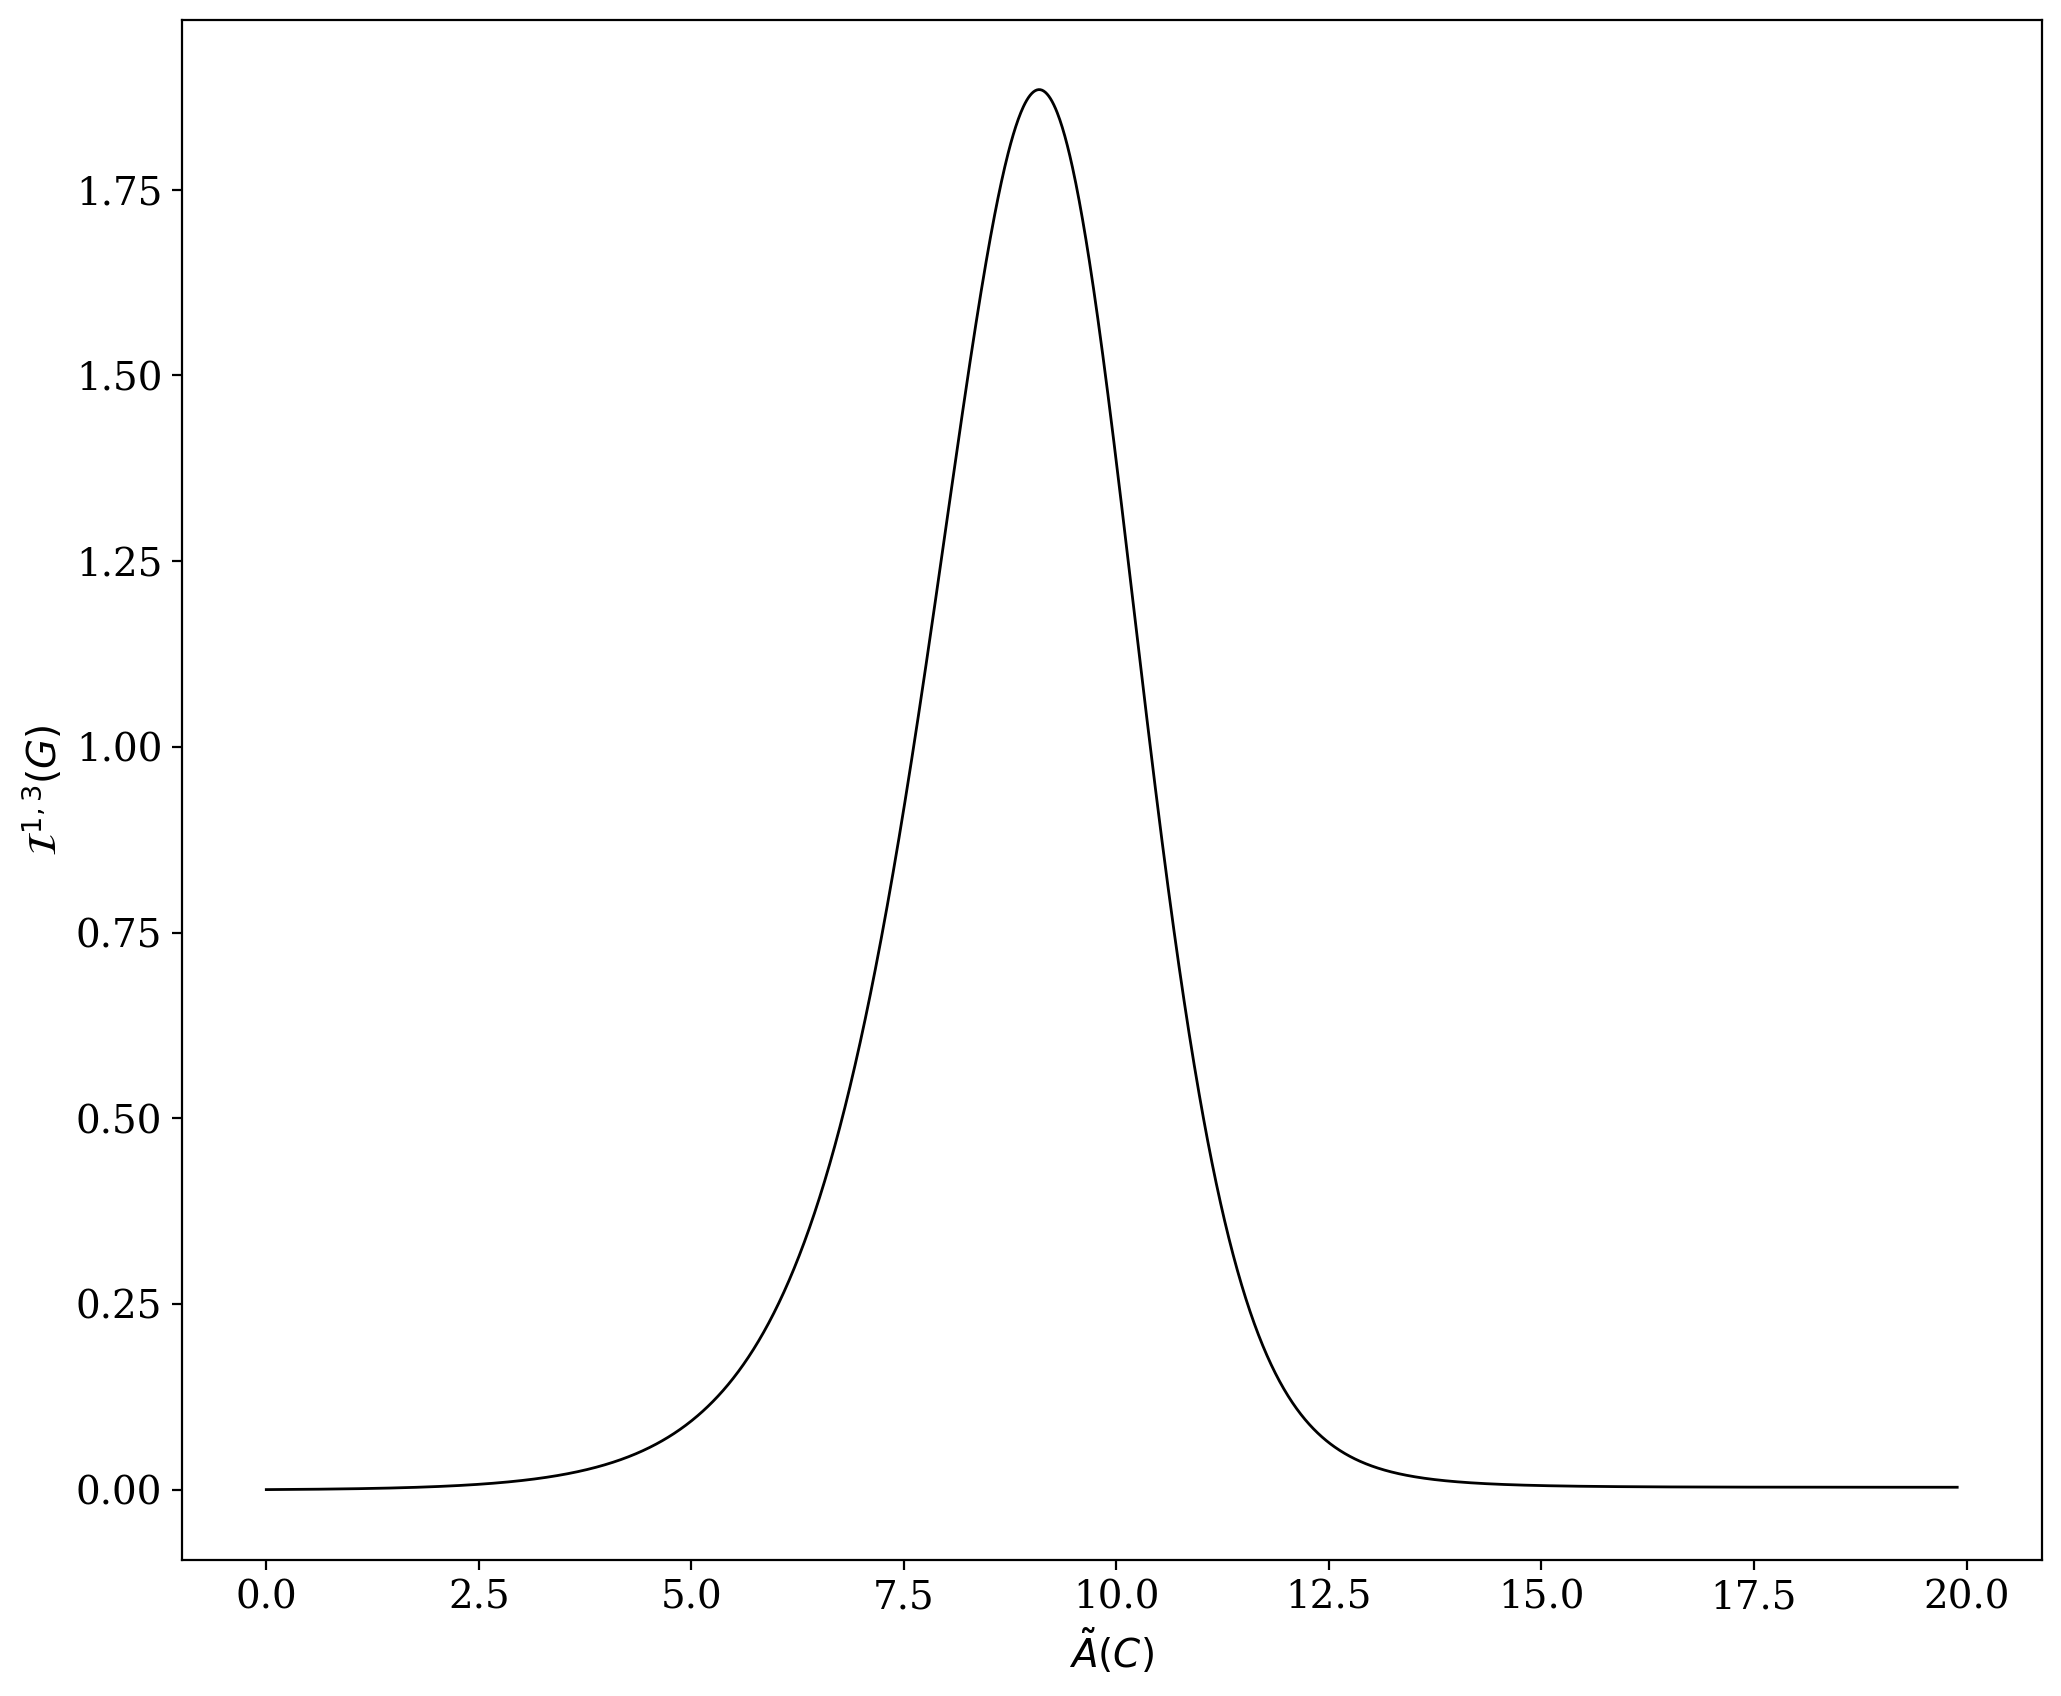

In [41]:
# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

This is much better, I think.

# Random parameter sets

In [67]:
labels_f, labels_r = eq_params_k4_2cycle()
print(labels_f)
print(labels_r)

[[0.0003873879436428067, 17.54, 0.009573], [2.312, 12578.928975548963, 0.001266]]
[[0.2092, 0.001266, 0.2456], [0.01761, 119.2, 17.54]]


In [68]:
aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
print(aff)

2.2204460492503128e-16


In [69]:
lap = lap_k4_2cycle(labels_f,labels_r)
print(lap)

[[-2.45987388e-01  2.09200000e-01  0.00000000e+00  9.57300000e-03]
 [ 3.87387944e-04 -2.00612000e+01  1.76100000e-02  1.26600000e-03]
 [ 0.00000000e+00  2.31200000e+00 -1.25789466e+04  1.19200000e+02]
 [ 2.45600000e-01  1.75400000e+01  1.25789290e+04 -1.19210839e+02]]


In [70]:
# check that eigenvalues are real and distinct (they need to stay this way)
lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

[-1.26981465e+04+0.j -2.00626063e+01+0.j -2.55480929e-01+0.j
  3.35399956e-15+0.j]


In [71]:
signal = [3,5,7,9]
alpha, beta  = 1, 3

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k21
cycle_idx = 0
edge_idx = 0
perturb_edge = labels_r[cycle_idx][edge_idx]
perturb_edge

for i in tqdm(range(0,N)):
    
    labels_r[cycle_idx][edge_idx] = perturb_edge
    
    lap = lap_k4_2cycle(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 9550.51it/s]


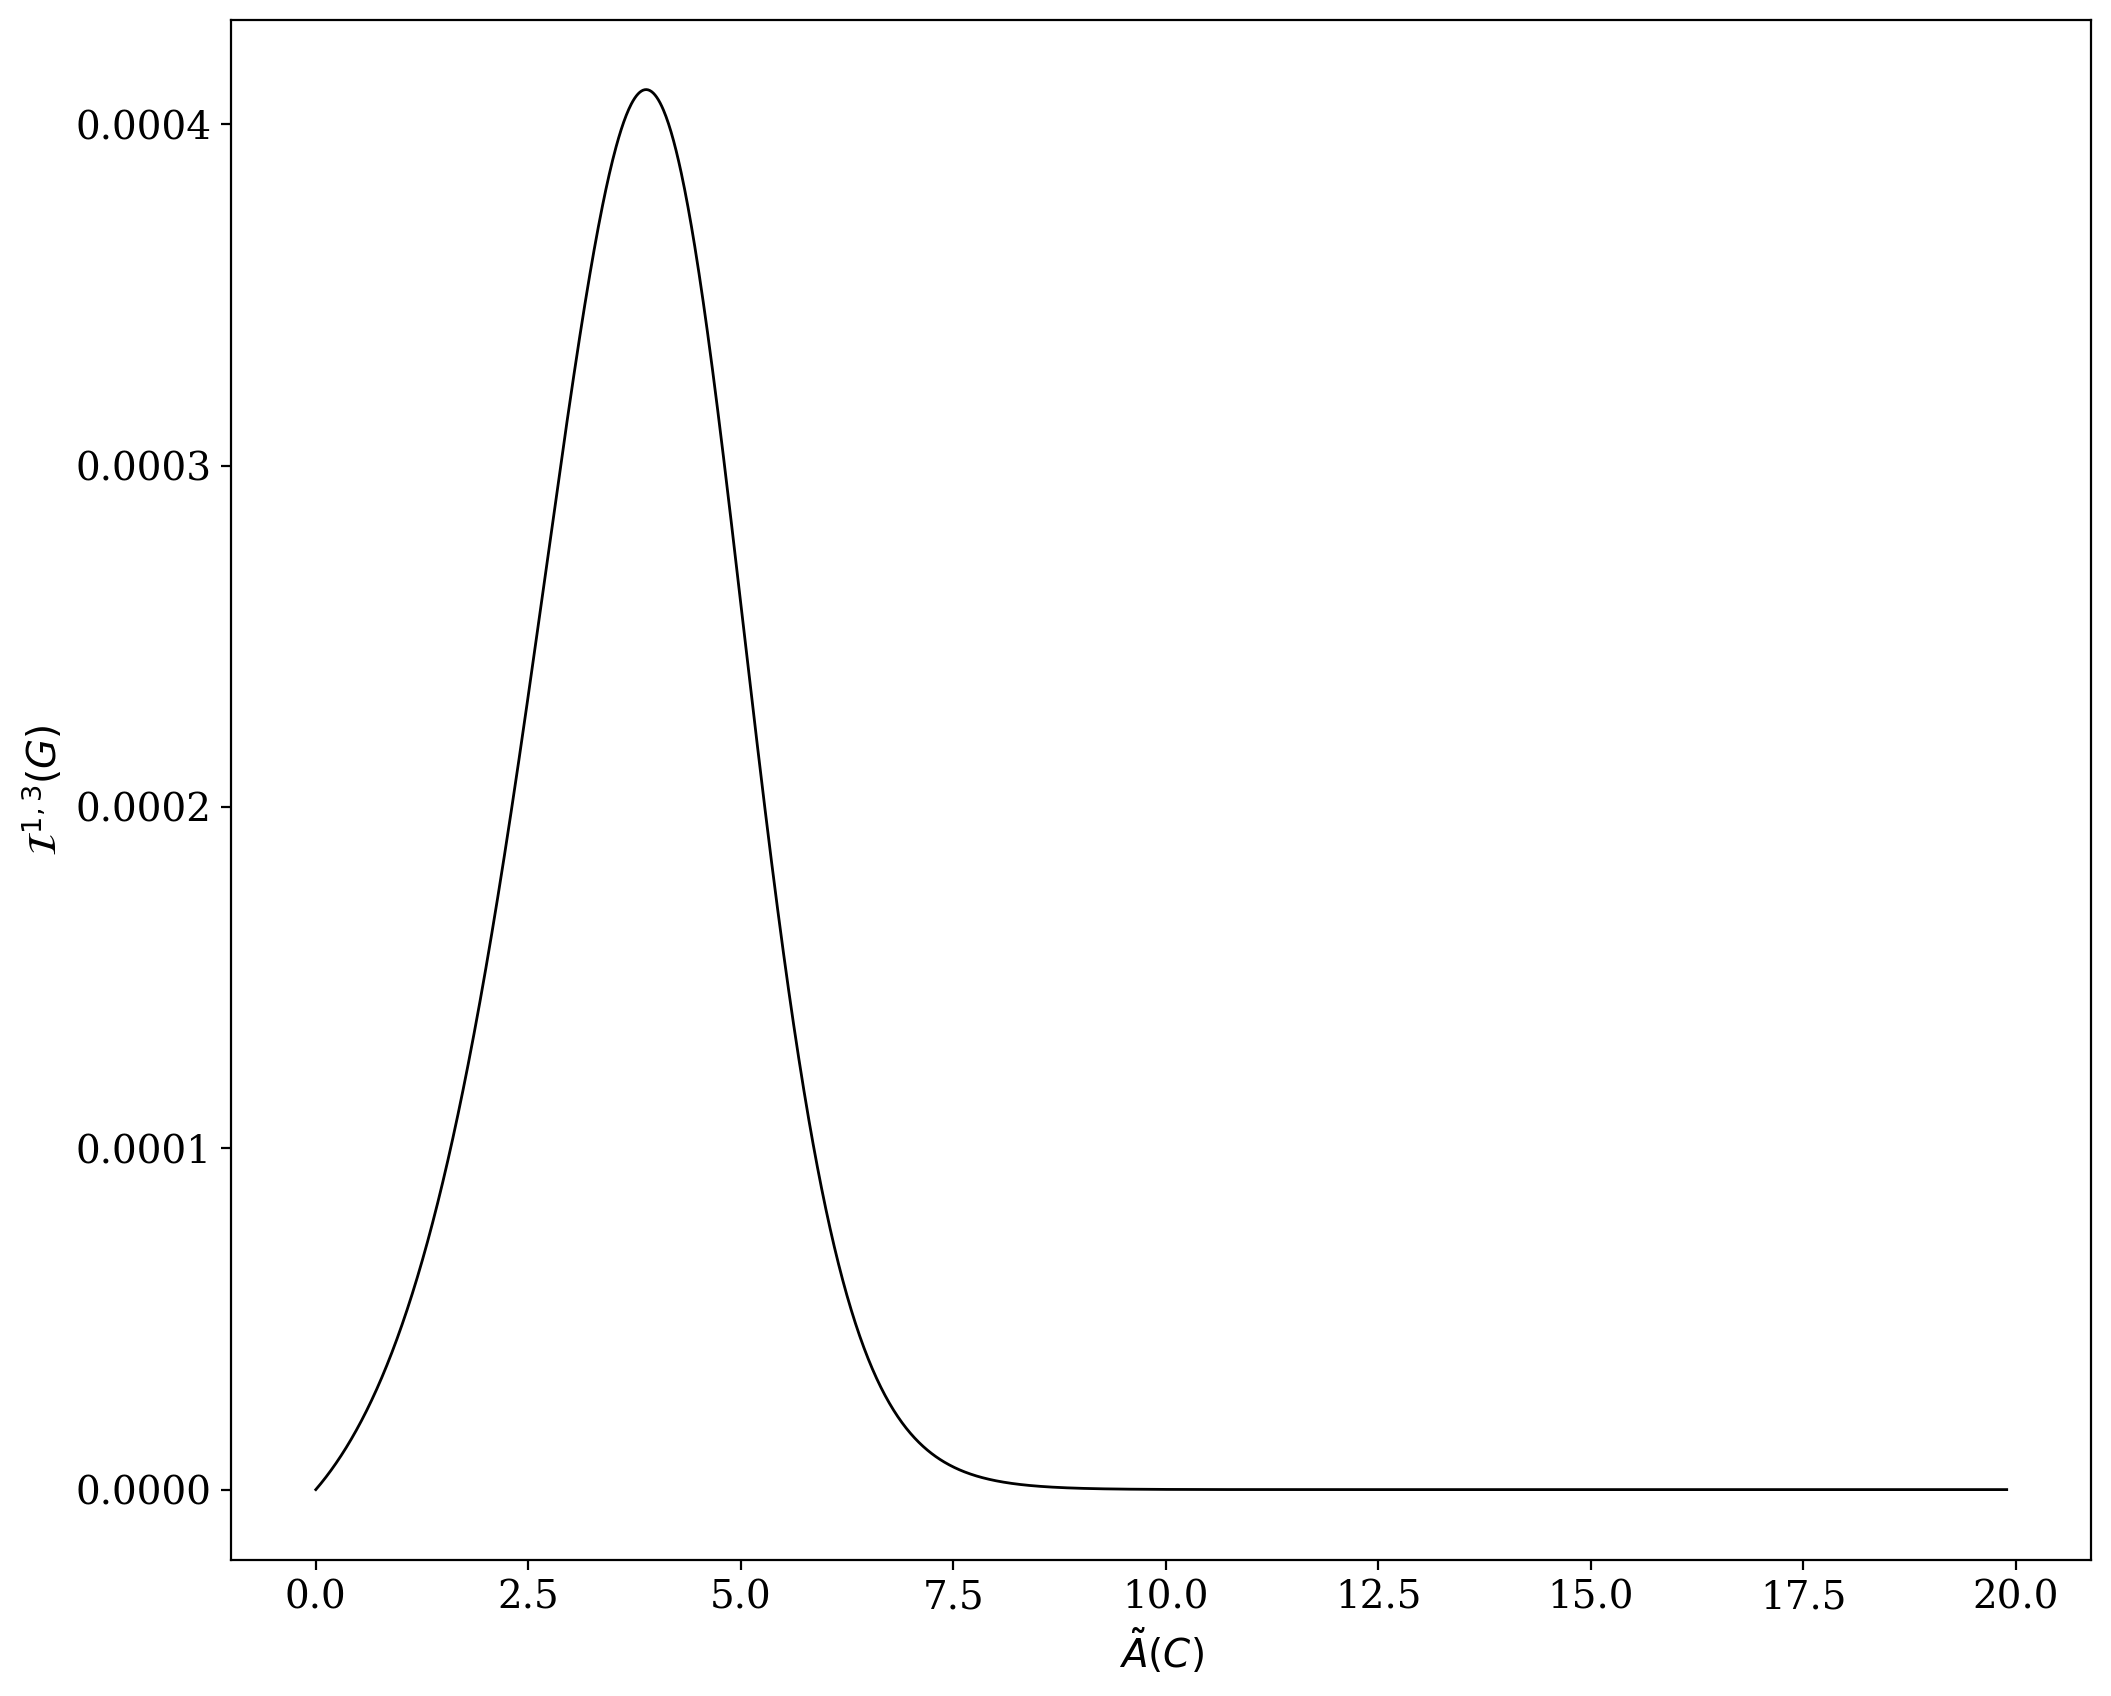

In [72]:
# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

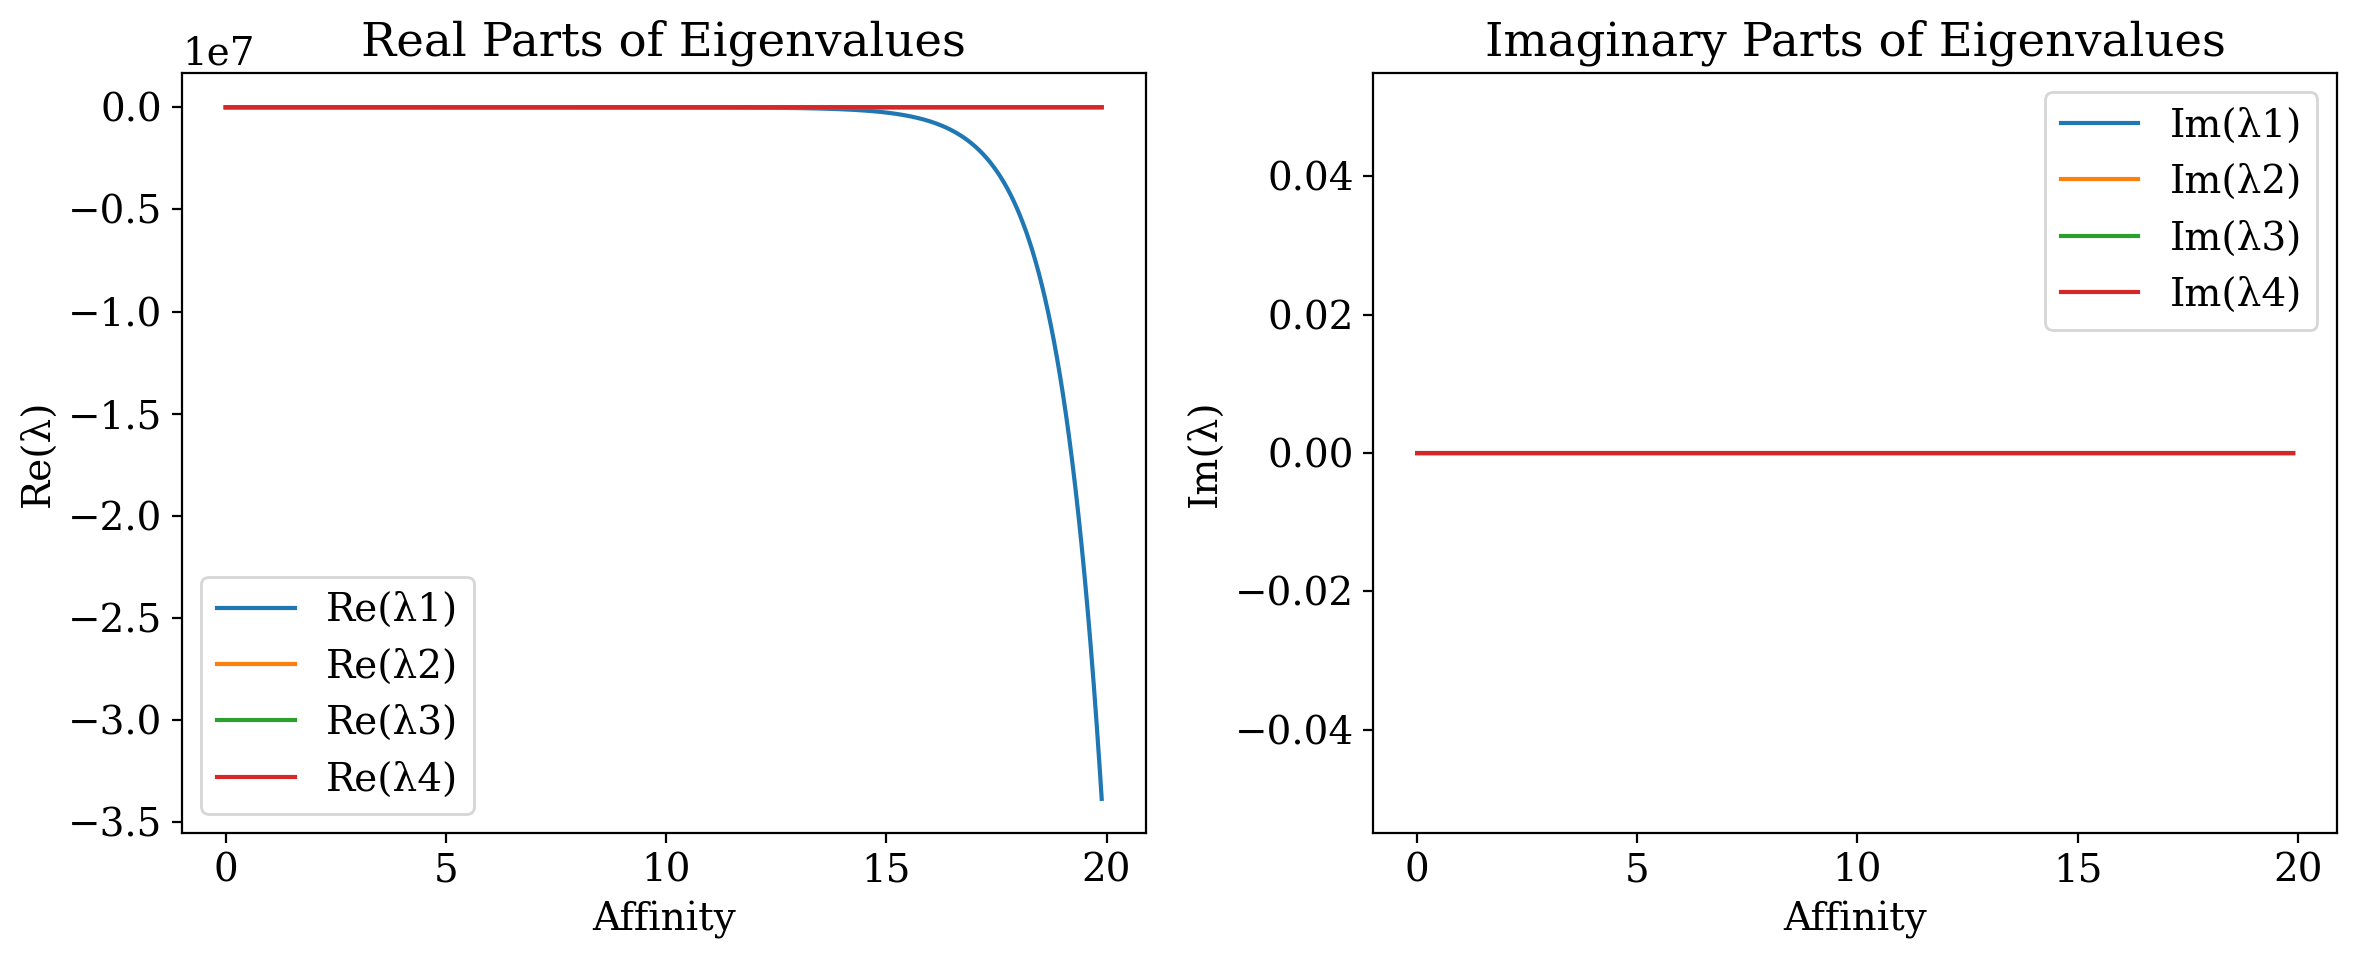

In [54]:
# Eigenvalues plots
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
#plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()

## One parameter set, each parameter perturbed

In [81]:
k12 = 4.031568597391051 
k24 = 0.6038
k41 = 0.1251
k23 = 19.22
k34 = 20.92595782981535
k42 = 0.04658
k21 = 0.2675
k14 = 24.44
k32 = 19.38 
k43 = 1.601

labels_f1 = [[k12, k24, k41], [k23, k34, k42]]
labels_r1 = [[k21, k42, k14], [k32, k43, k24]]

2.2204460492503128e-16
[[-28.4715686    0.2675       0.           0.1251    ]
 [  4.0315686  -20.0913      19.38         0.04658   ]
 [  0.          19.22       -40.30595783   1.601     ]
 [ 24.44         0.6038      20.92595783  -1.77268   ]]
[-5.24743078e+01+0.j -2.85805153e+01+0.j -9.58668337e+00+0.j
  6.77322315e-15+0.j]


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 9633.59it/s]


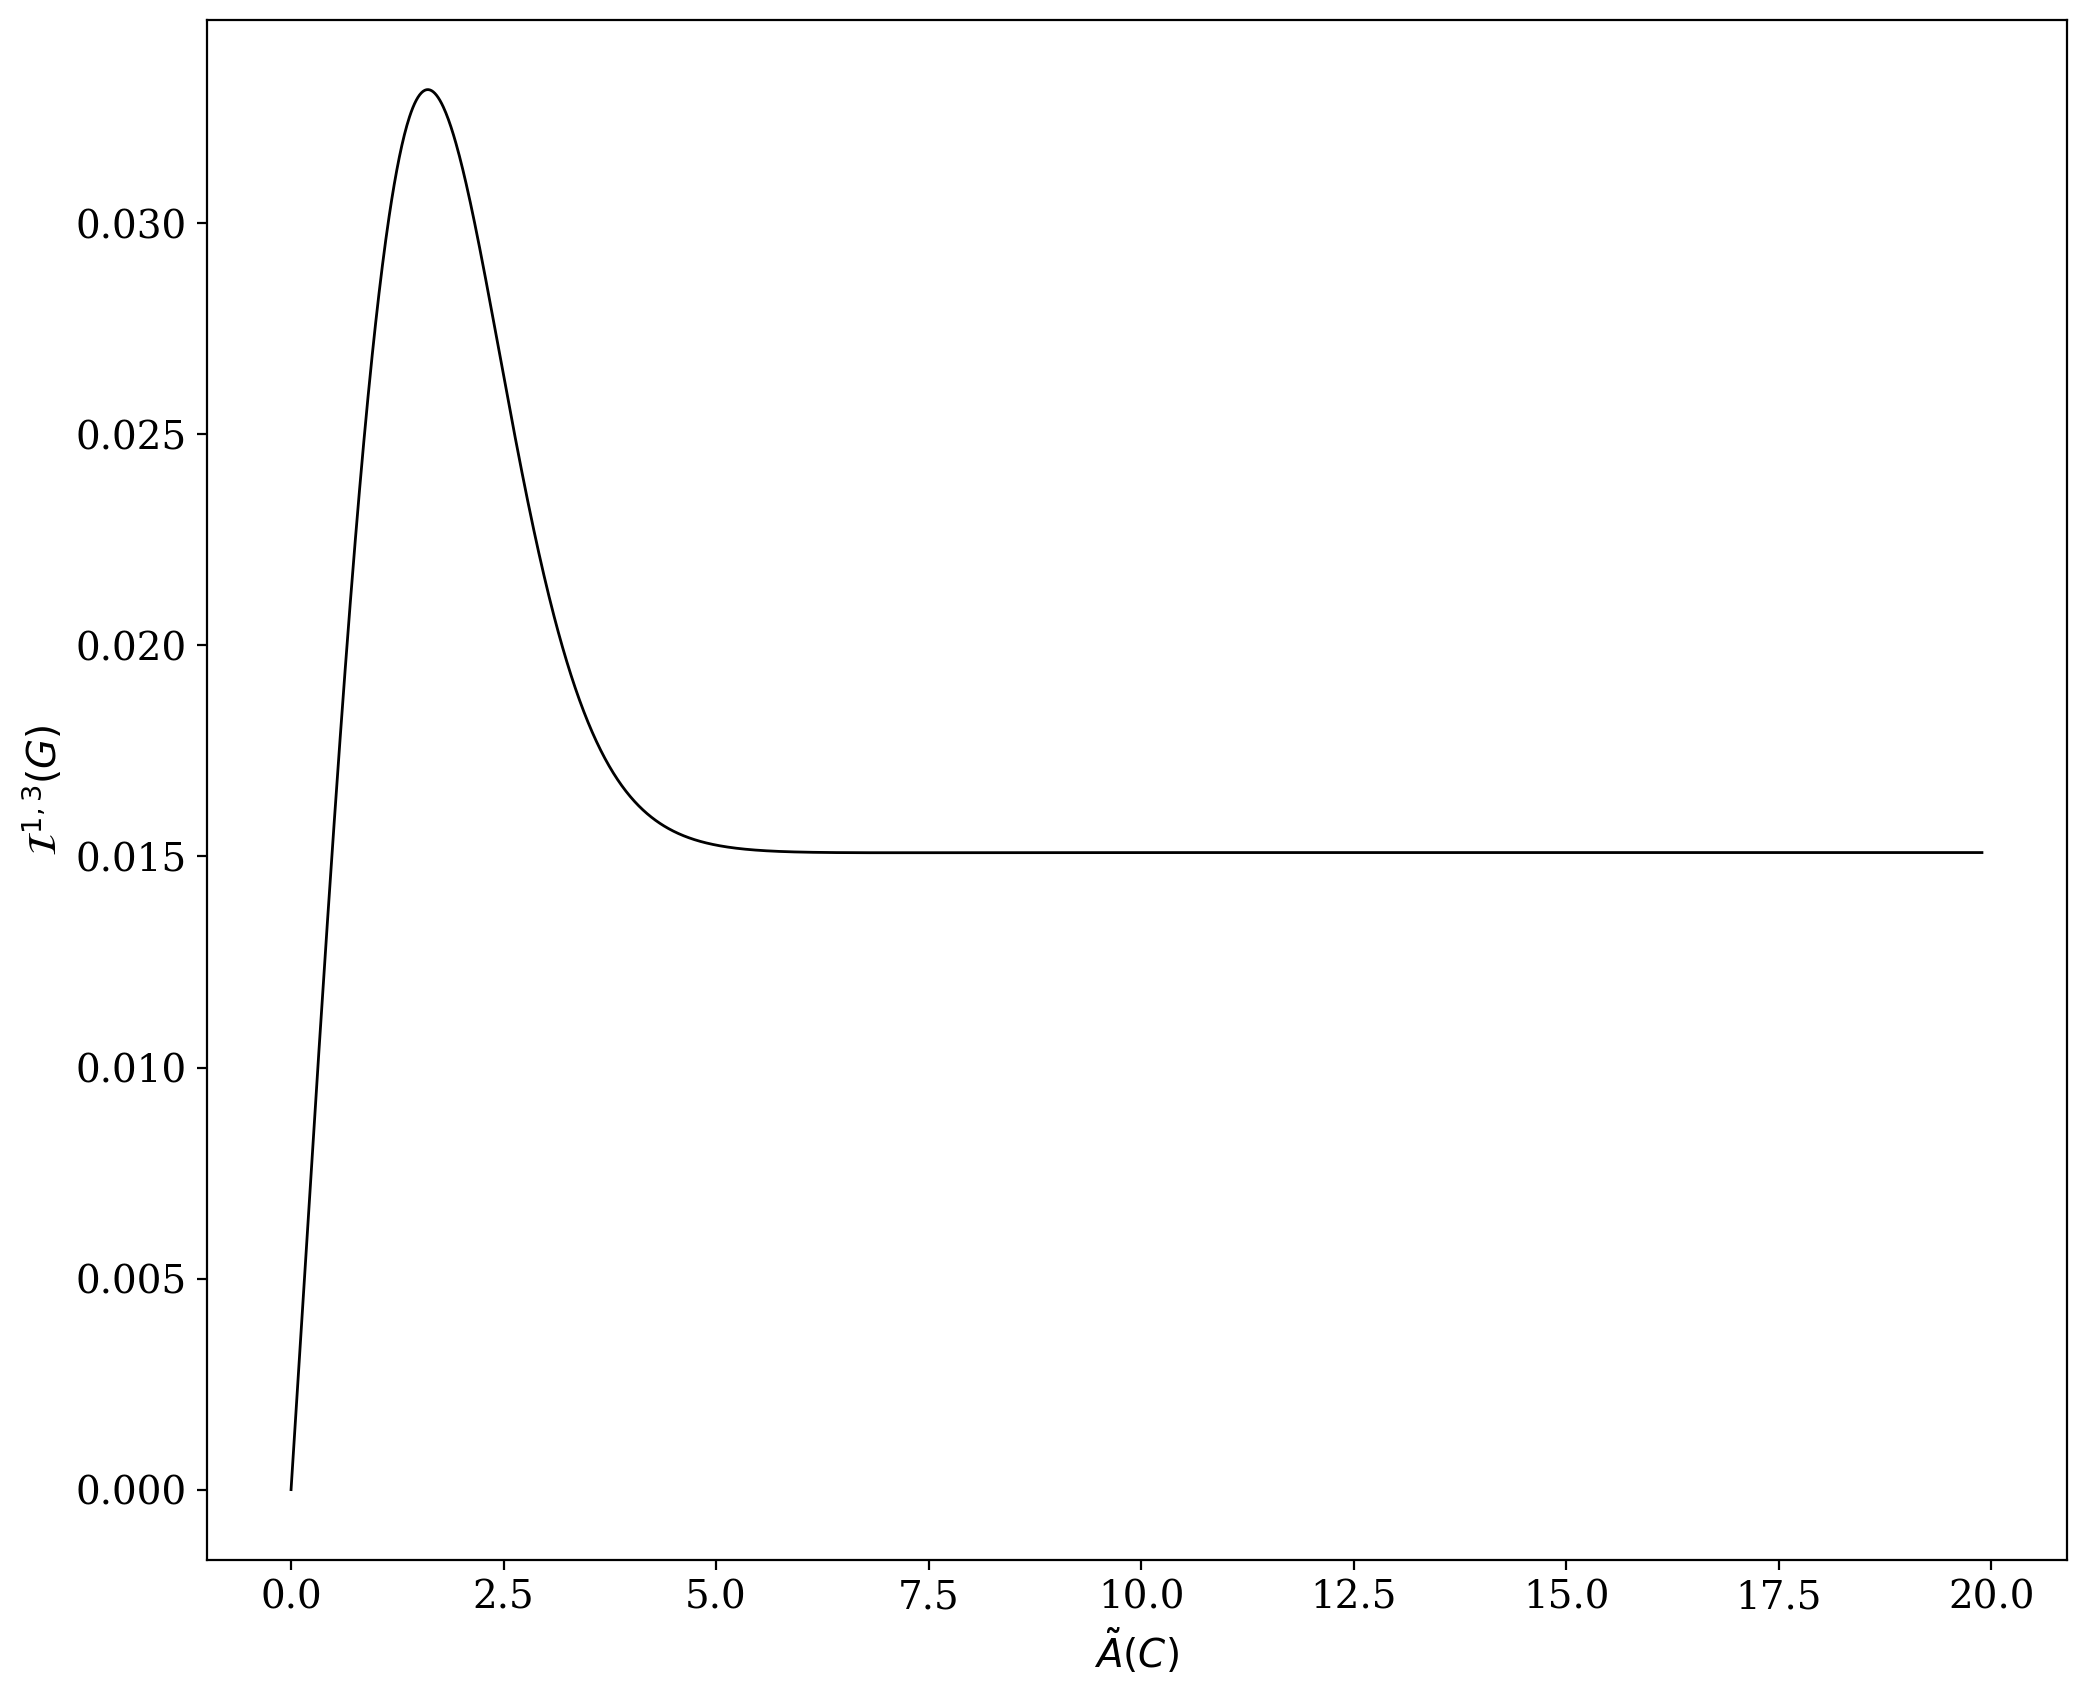

In [82]:
aff = np.abs(np.log(np.prod(labels_f1)/np.prod(labels_r1)))
print(aff)

lap = lap_k4_2cycle(labels_f1,labels_r1)
print(lap)

lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

signal = [3,5,7,9]
alpha, beta  = 1, 3

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k12
cycle_idx = 0
edge_idx = 0
perturb_edge = labels_f1[cycle_idx][edge_idx]
perturb_edge

for i in tqdm(range(0,N)):
    
    labels_f1[cycle_idx][edge_idx] = perturb_edge
    
    lap = lap_k4_2cycle(labels_f1, labels_r1)
    
    aff = np.abs(np.log(np.prod(labels_f1)/np.prod(labels_r1)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

In [84]:
k12 = 4.031568597391051 
k24 = 0.6038
k41 = 0.1251
k23 = 19.22
k34 = 20.92595782981535
k42 = 0.04658
k21 = 0.2675
k14 = 24.44
k32 = 19.38 
k43 = 1.601

labels_f2 = [[k12, k24, k41], [k23, k34, k42]]
labels_r2 = [[k21, k42, k14], [k32, k43, k24]]

2.2204460492503128e-16
[[-28.4715686    0.2675       0.           0.1251    ]
 [  4.0315686  -20.0913      19.38         0.04658   ]
 [  0.          19.22       -40.30595783   1.601     ]
 [ 24.44         0.6038      20.92595783  -1.77268   ]]
[-5.24743078e+01+0.j -2.85805153e+01+0.j -9.58668337e+00+0.j
  6.77322315e-15+0.j]


100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 9733.45it/s]


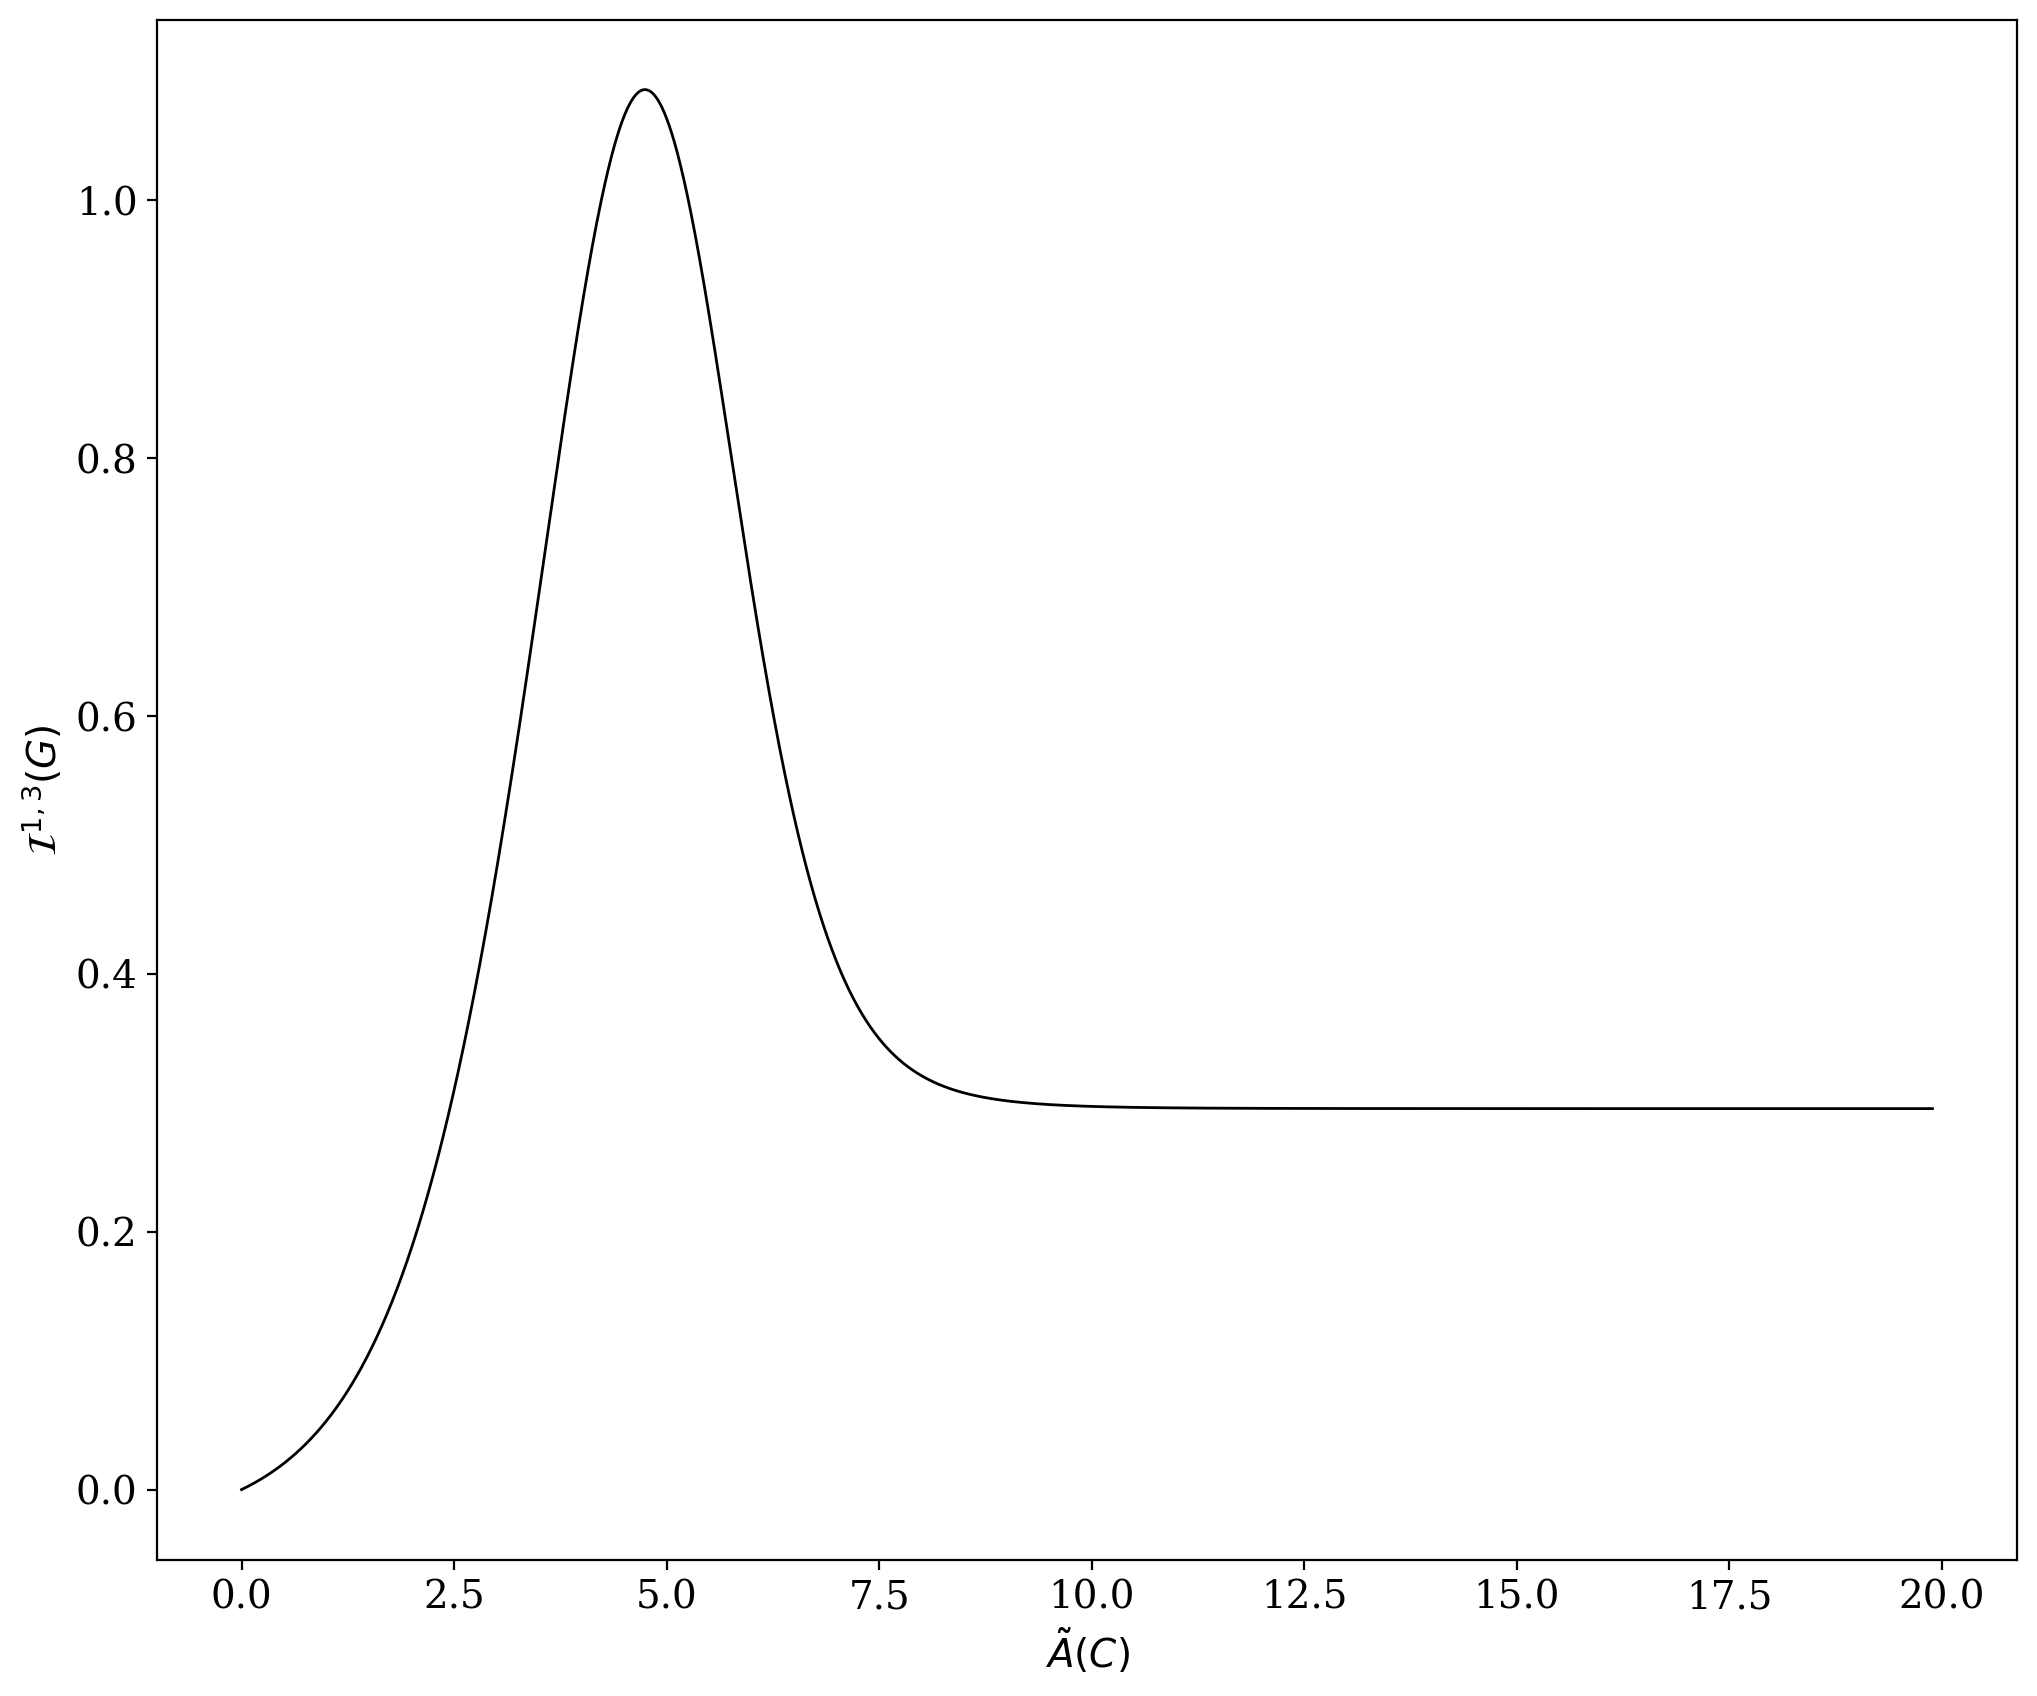

In [85]:
aff = np.abs(np.log(np.prod(labels_f2)/np.prod(labels_r2)))
print(aff)

lap = lap_k4_2cycle(labels_f2,labels_r2)
print(lap)

lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

signal = [3,5,7,9]
alpha, beta  = 1, 3

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k41
cycle_idx = 0
edge_idx = 2
perturb_edge = labels_f2[cycle_idx][edge_idx]
perturb_edge

for i in tqdm(range(0,N)):
    
    labels_f2[cycle_idx][edge_idx] = perturb_edge
    
    lap = lap_k4_2cycle(labels_f2, labels_r2)
    
    aff = np.abs(np.log(np.prod(labels_f2)/np.prod(labels_r2)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()

In [86]:
k12 = 4.031568597391051 
k24 = 0.6038
k41 = 0.1251
k23 = 19.22
k34 = 20.92595782981535
k42 = 0.04658
k21 = 0.2675
k14 = 24.44
k32 = 19.38 
k43 = 1.601

labels_f3 = [[k12, k24, k41], [k23, k34, k42]]
labels_r3 = [[k21, k42, k14], [k32, k43, k24]]

2.2204460492503128e-16
[[-28.4715686    0.2675       0.           0.1251    ]
 [  4.0315686  -20.0913      19.38         0.04658   ]
 [  0.          19.22       -40.30595783   1.601     ]
 [ 24.44         0.6038      20.92595783  -1.77268   ]]
[-5.24743078e+01+0.j -2.85805153e+01+0.j -9.58668337e+00+0.j
  6.77322315e-15+0.j]


100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 10028.33it/s]


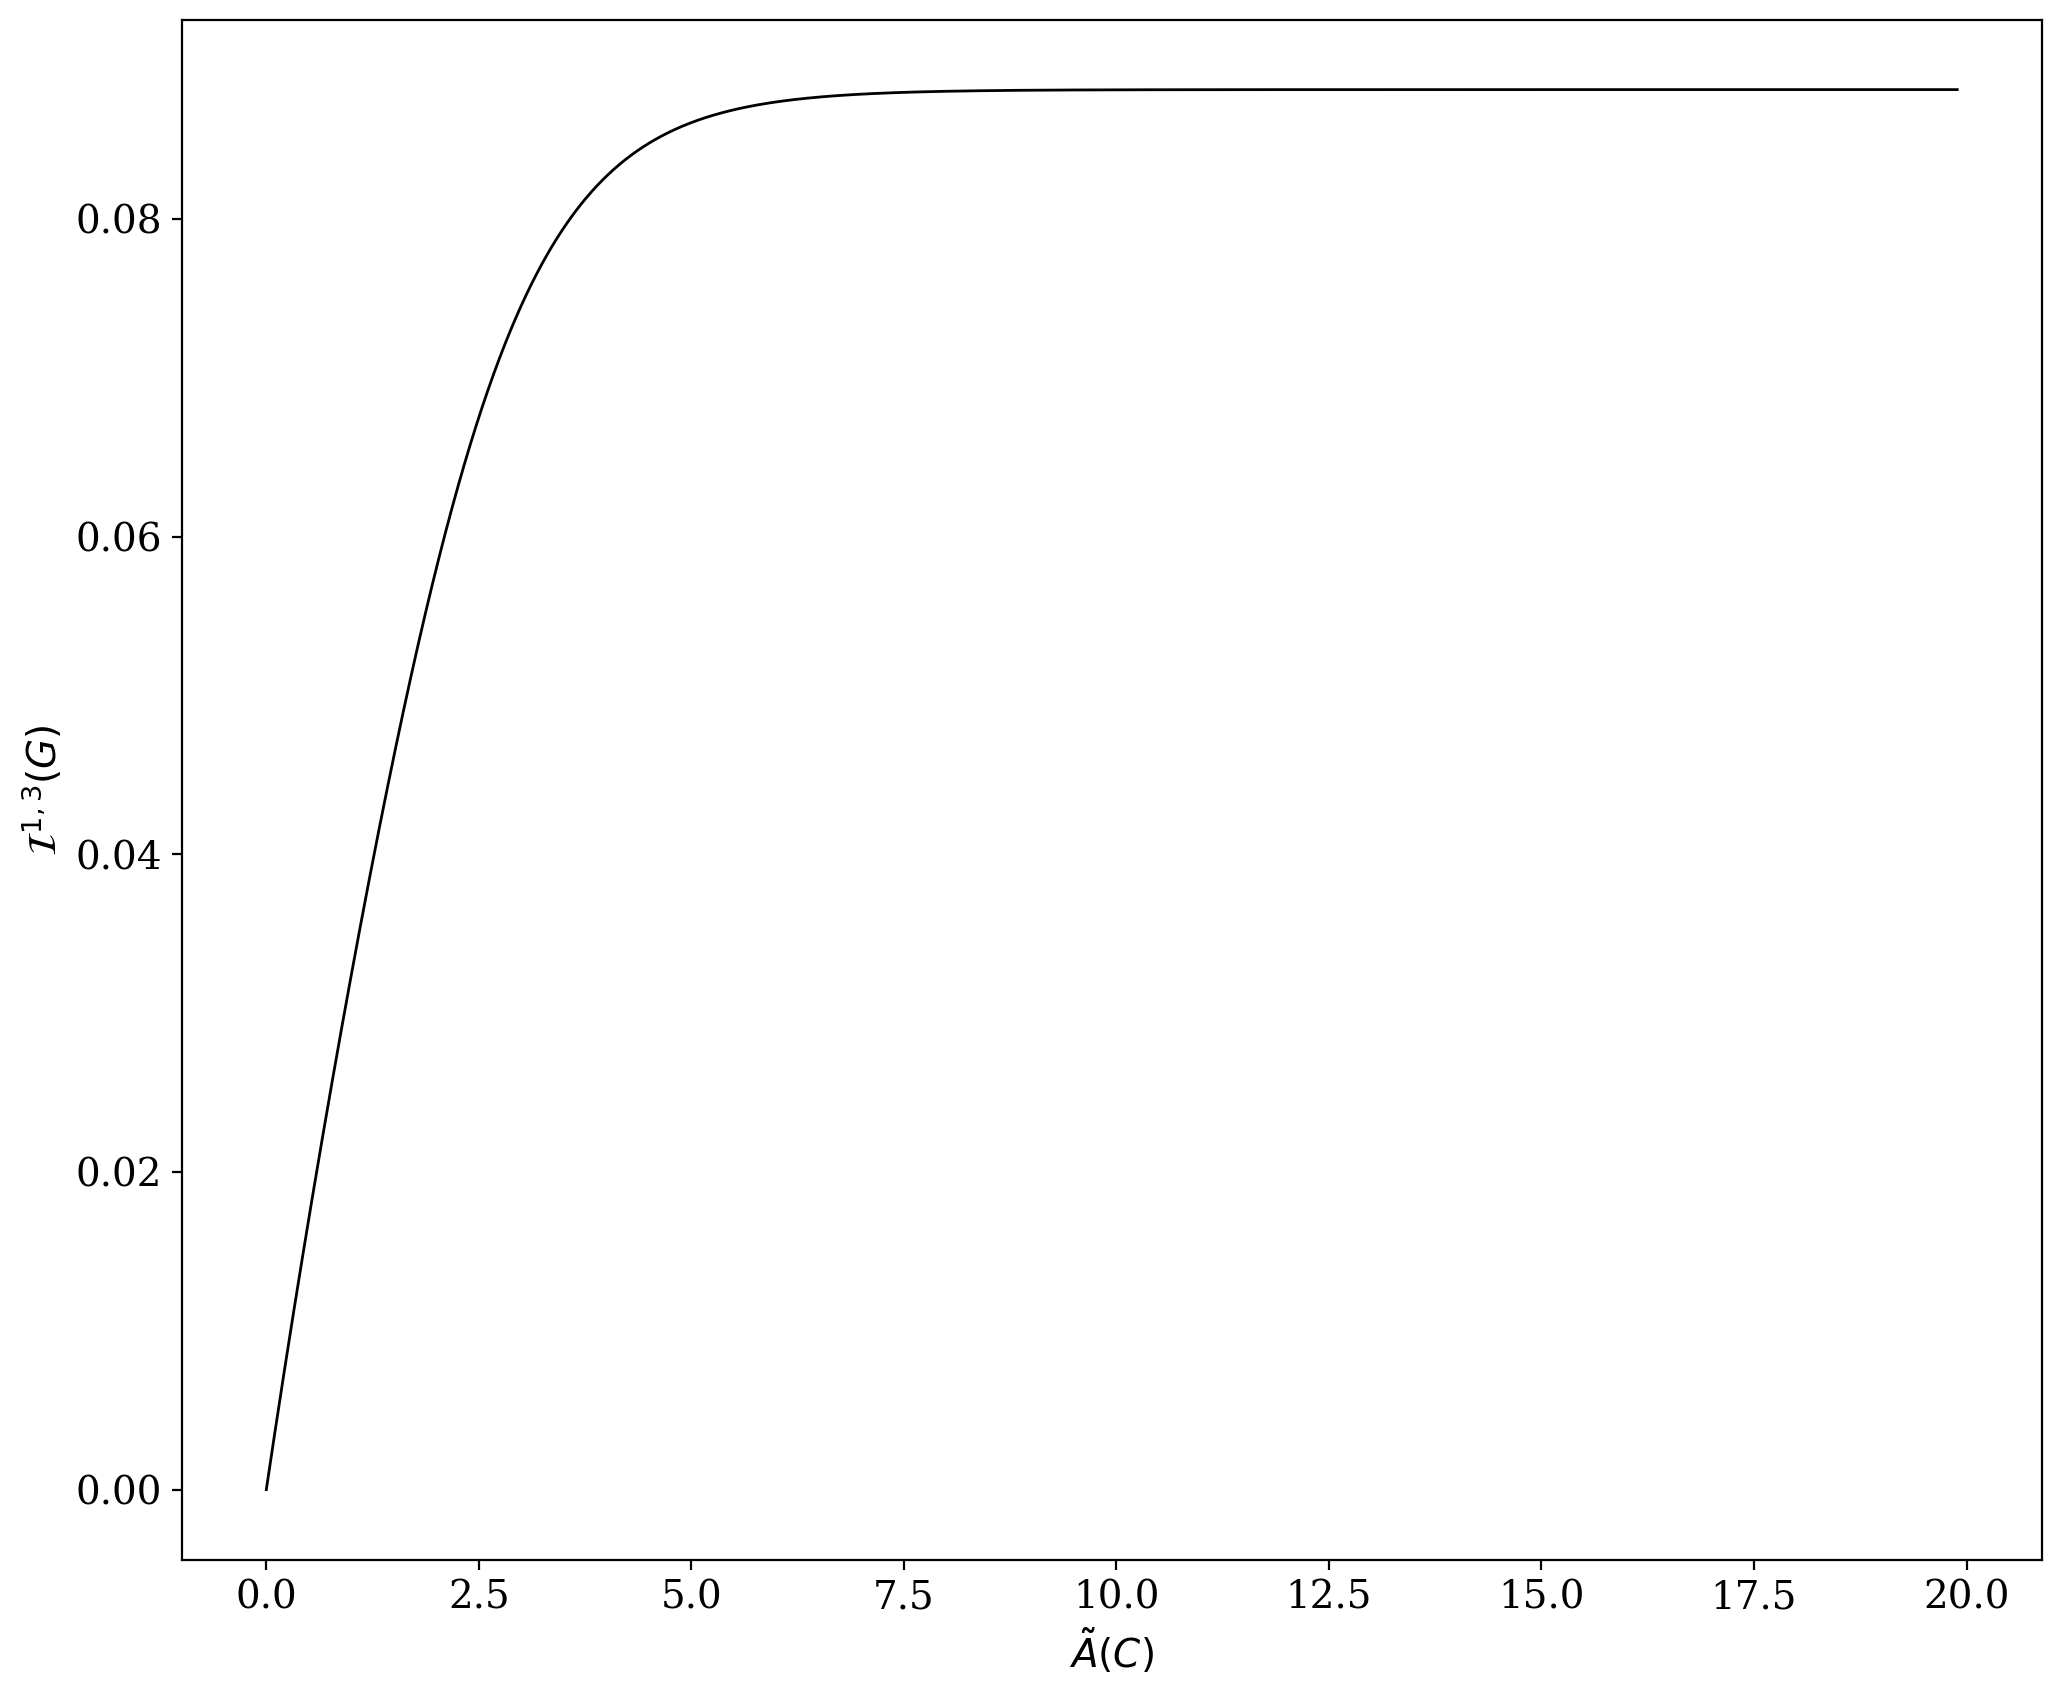

In [87]:
aff = np.abs(np.log(np.prod(labels_f3)/np.prod(labels_r3)))
print(aff)

lap = lap_k4_2cycle(labels_f3,labels_r3)
print(lap)

lambdas, w_i, z_i = spectrum_any(lap)
print(lambdas)

signal = [3,5,7,9]
alpha, beta  = 1, 3

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N)
eigvals_all_r = np.zeros((N, 4), dtype=float)
eigvals_all_c = np.zeros((N, 4), dtype=float)

# perturb edge k23
cycle_idx = 1
edge_idx = 0
perturb_edge = labels_f3[cycle_idx][edge_idx]
perturb_edge

for i in tqdm(range(0,N)):
    
    labels_f3[cycle_idx][edge_idx] = perturb_edge
    
    lap = lap_k4_2cycle(labels_f3, labels_r3)
    
    aff = np.abs(np.log(np.prod(labels_f3)/np.prod(labels_r3)))
    affinities[i] = aff
    
    areas[i] = np.abs(steinberg_analytical_area(signal,lap,alpha=1,beta=3))

    lambdas, w_i, z_i = spectrum_any(lap)
    eigvals_all_r[i, :] = np.sort(lambdas.real)
    eigvals_all_c[i, :] = np.sort(lambdas.imag)
    
    perturb_edge *= 1.01

# Steinberg curve plot
plt.plot(np.abs(affinities),areas,label=r'$\mathcal{I}^{1,3}(G)$',linewidth=1, color= 'black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.show()